# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- Starter Code was tested on Python 3.11.11

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [1]:
import numpy as np
import random
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
"""Here is the implementation of the 10-armed Bandit problem/testbed. DO NOT CHANGE 
   Note that:
       - call the reset function whenever you want to generate a new 10-armed Bandit problem
"""
class Bandit(object):
    def __init__(self, k=10):
        # Number of the actions
        self.k = k

        # Numpy array to store the true action value the k arms/actions
        self.q_star = np.empty(self.k)

    def reset(self):
        # Reset the true action values to generate a new k-armed bandit problem
        # Value for each arm is randomly sampled from a normal distribution 
        # with mean = 0, variance = 1.0. 
        self.q_star = np.random.normal(loc=0, scale=1, size=self.k)
        
    def best_action(self):
        """Return the indices of all best actions/arms in a list variable
        """
        return np.where(self.q_star == self.q_star.max())[0].tolist()  

    def step(self, act):
        """
        Args:
            act (int): index of the action
        """
        # Compute the reward for each action
        # The reward for each action at time step t is sampled from a Gaussian distribution
        # For the k-th arm, the mean = q_star[k] (true value) and variance = 1
        rewards = np.random.normal(loc=self.q_star, scale=np.ones(10), size=self.k)
        return rewards[act]

In [3]:
"""Here is the plotting function you can directly use to plot the figures needed for Q5 and Q6
"""

# plot function
def plot_curves(arr_list, legend_list, color_list, upper_bound, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        upper_bound (numpy array): array contains the best possible rewards for 2000 runs. the shape should be (2000,)
        ylabel (string): label of the Y axis
        
        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly. 
        Do not forget to change the ylabel for different plots.
        
        To plot the upper bound for % Optimal action figure, set upper_bound = np.ones(num_step), where num_step is the number of steps.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Steps")
    ax.set_ylim(-0.1, upper_bound.mean() + 0.1)
    
    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        #ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3, color=color)
        # save the plot handle
        h_list.append(h) 
    
    # plot the upper bound
    h = plt.axhline(y=upper_bound.mean(), color='k', linestyle='--', label="upper bound")
    h_list.append(h)
    
    # plot legends
    ax.legend(handles=h_list)  
    plt.show()

# Q1: Implement 10-armed Bandit

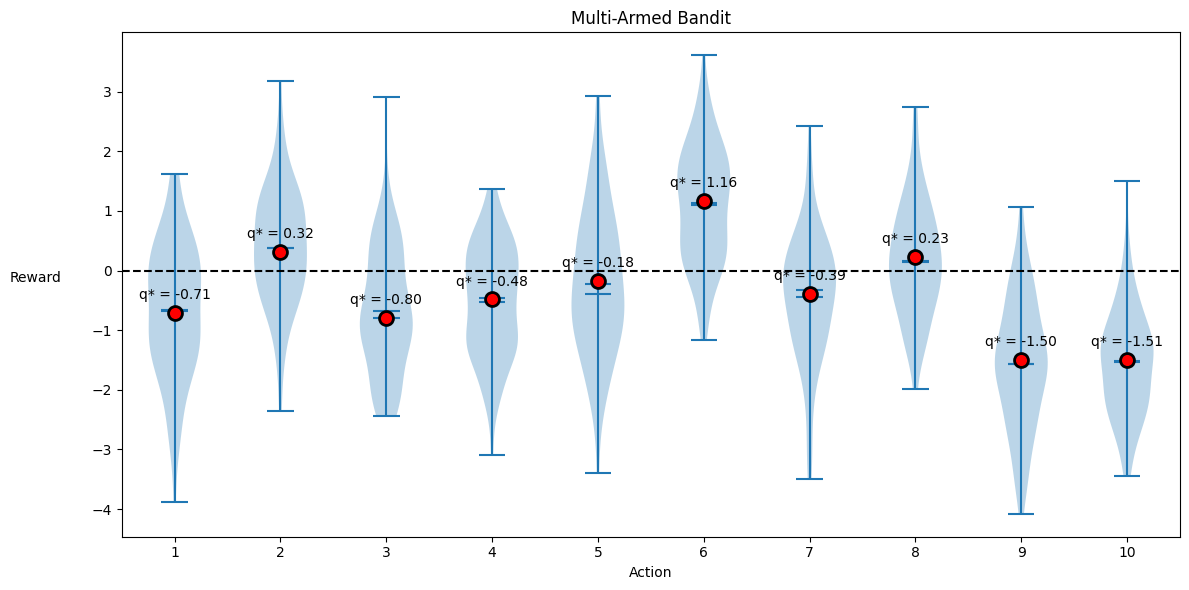

In [4]:
def MultiArmBandit(k: int, num_samples: int):
    """Q4

    Structure:
        1. Create multi-armed bandit env
        2. Pull each arm `num_samples` times and record the rewards
        3. Plot the rewards (e.g. violinplot, stripplot)

    Args:
        k (int): Number of arms in bandit environment
        num_samples (int): number of samples to take for each arm
    """

    env = Bandit(k=k)
    env.reset()

    all_rewards = []
    #collect rewards for each arm
    for i in range(k):
        arm_rewards  = [env.step(i) for _ in range(num_samples)] # collect rewards from each step loop through
        all_rewards.append(arm_rewards) # add to the list

    #plot the rewards
    fig, ax = plt.subplots(figsize=(12, 6))

    parts = ax.violinplot(all_rewards, showmeans=True, showmedians=True)

    #add horizontal line for y=0
    ax.axhline(y=0, color='black', linestyle='--')

    #mark the true action values for each arm the secret q*'set
    for i in range(k):
        ax.plot(i+1, env.q_star[i], 'ro', markersize=10, markeredgewidth=2, markeredgecolor='black') 
        ax.annotate(f'q* = {env.q_star[i]:.2f}', (i+1, env.q_star[i]), textcoords="offset points", xytext=(0,10), ha='center')  


    # set the labels
    ax.set_xlabel('Action')
    ax.set_ylabel('Reward', rotation=0, labelpad=40)
    ax.set_title('Multi-Armed Bandit')
    ax.set_xticks(range(1, k+1))
    ax.set_xlim(0.5, k+0.5)

    plt.tight_layout()
    plt.show()  


#call the function
MultiArmBandit(k=10, num_samples=100)#exactly like in the book 
    


    

# Q2: Implement ε-greedy algorithm with incremental update

The following is the scaffolding code for the epsilon-greedy agent. 

    1. Reset function: reset the Q value for each arm/action to be self.init. (e.g., self.init = 0)
    
    2. Choose action: select the arm/action using epsilon-greedy strategy.
    
    3. Update: update the time steps, Q values for k arms/actions and numbers of selecting each arm/action.
    
    4. argmax: find the indices of all maximal values in a numpu array.
    
Please finish the code under "CODE HERE"

In [5]:
class EpsilonGreedyAgent(object):
    def __init__(self, k: int, init: int, epsilon: float, alpha: float = None ) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            epsilon (float): random action probability
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.epsilon = epsilon

        #alph add for question 2.5
        self.alpha = alpha

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self) -> int:
        """Choose which arm to pull

        With probability 1 - epsilon, choose the best action (break ties arbitrarily, use argmax() from above).
        
        With probability epsilon, choose a random action.
        """
        # CODE HERE: please implement the epsilon-greedy strategy to select the action
        probability = np.random.random()
        if probability < self.epsilon:
            return np.random.randint(self.k)
        else:
            return self.argmax(self.Q)  
        
    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1
        self.N[action] += 1 
        
        self.Q[action] = self.Q[action] + (1.0 / self.N[action]) * (reward - self.Q[action])  

        # CODE HERE: implement the incremental update
        # update the self.N
        
        # CODE HERE: update self.Q with the incremental update
        # Note: please use the sample-average technique in equation 2.1


    @staticmethod
    def argmax(arr) -> int:
        """Argmax that breaks ties randomly

        Takes in a list of values and returns the index of the item with the highest value, breaking ties randomly.

        Note: np.argmax returns the first index that matches the maximum, so we define this method to use in EpsilonGreedy and UCB agents.
        Args:
            arr: sequence of values
        """
        #CODE HERE: implement argmax_a Q(a) for the greedy action selection, breaking ties randomly.

        max_val = np.max(arr)
        max_idx = np.where(arr == max_val)[0]
        return np.random.choice(max_idx)    
        # return int

In [6]:
""" Here is the function to run the epsilon greedy agent. Please complete the missing part under "CODE HERE"
"""
# run epsilon greedy 
def run_epsilon_greedy_agent(run_num, time_step, epsilon=0.0, init=0.0, alpha=None):
    """
    Args:
        run_num (int): number of runs
        time_step (int): number of time steps per run
        epsilon (float): epsilon for the agent
        init (float): initial value for the Q. (i.e., Q1)
    """
    # DO NOT CHANGE: create the 10-armed Bandit problem
    k = 10
    env = Bandit(k)
    env.reset()

    # DO NOT CHANGE: create the agent with proper initial value and epsilon
    agent = EpsilonGreedyAgent(k=k, init=init, epsilon=epsilon, alpha=alpha)
    agent.reset()

    # DO NOT CHANGE: create a numpy array to store rewards with shape (run_num, time_step)
    # For example, results_rewards[r, t] stores the reward for step t in the r-th running trail
    results_rewards = np.empty((run_num, time_step))
    
    # DO NOT CHANGE: create a numpy array to store optimal action proportion with shape (run_num, time_step)
    # For example, results_action[r, t] stores 1 if the selected action at step t in the r-th runing trail is optimal
    # and 0 otherwise.
    results_action = np.empty((run_num, time_step))
    
    # DO NOT CHANGE: create a numpy array to save upper_bound (only for plotting rewards; it should be 1 for plotting action optimality proportion)
    # For example, upper_bound[r] stores the true action value for the r-th running trail.
    upper_bound = np.empty(run_num)
    

    # loop for trails starts
    for r in tqdm.tqdm(range(run_num), desc="run number", position=0):
        
        # CODE HERE: reset the environment to create a new 10-armed bandit problem.
        env.reset()
        # CODE HERE: reset the agent
        agent.reset()
        
        # CODE HERE: compute the upper bound for each running trial and update upper_bound[r]
        upper_bound[r] = np.max(env.q_star)
        
        # loop for each trail a fixed number of steps
        for t in tqdm.tqdm(range(time_step), desc="time step", position=1, leave=False):
            
            # CODE HERE: get the best action to execute at step t 
            # act = int
            act = agent.choose_action() 
            # CODE HERE: interact with the environment to receive rewards
            # reward = float
            reward = env.step(act)
            
            # Code HERE: update the agent based on the observed reward
            agent.update(act, reward)   
                     
            """DO NOT CHANGE BELOW"""
            # save the reward
            results_rewards[r, t] = reward
            # check and save whether the action is optimal
            if act in env.best_action():
                results_action[r, t] = 1
            else:
                results_action[r, t] = 0
            
    return results_rewards, results_action, upper_bound

In [7]:
"""Here is the implementation for running the experiment. You have to run the "run_epsilon_greedy_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 100
"""
# always set the random seed for results reproduction
np.random.seed(1234)
random.seed(1234)
    
# set the running parameters (Use 2000 runs and 1000 steps for final report)
run_num = 2000
time_step = 1000
    
# CODE HERE: 
rewards_eps0, actions_eps0, upper_bound_eps0 = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.0, init=0.0
)
# 2. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.01
rewards_eps001, actions_eps001, upper_bound_eps001 = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.01, init=0.0
)
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1
rewards_eps01, actions_eps01, upper_bound_eps01 = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=0.0
)
'''
# 2. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.01
rewards_eps001, actions_eps001, upper_bound_eps001 = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.01, init=0.0
)
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1
rewards_eps01, actions_eps01, upper_bound_eps01 = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=0.0
)
'''
# 1. run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.0
# 2. run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.01
# 3. run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

'\n# 2. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.01\nrewards_eps001, actions_eps001, upper_bound_eps001 = run_epsilon_greedy_agent(\n    run_num=run_num, time_step=time_step, epsilon=0.01, init=0.0\n)\n# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1\nrewards_eps01, actions_eps01, upper_bound_eps01 = run_epsilon_greedy_agent(\n    run_num=run_num, time_step=time_step, epsilon=0.1, init=0.0\n)\n'

<Figure size 640x480 with 0 Axes>

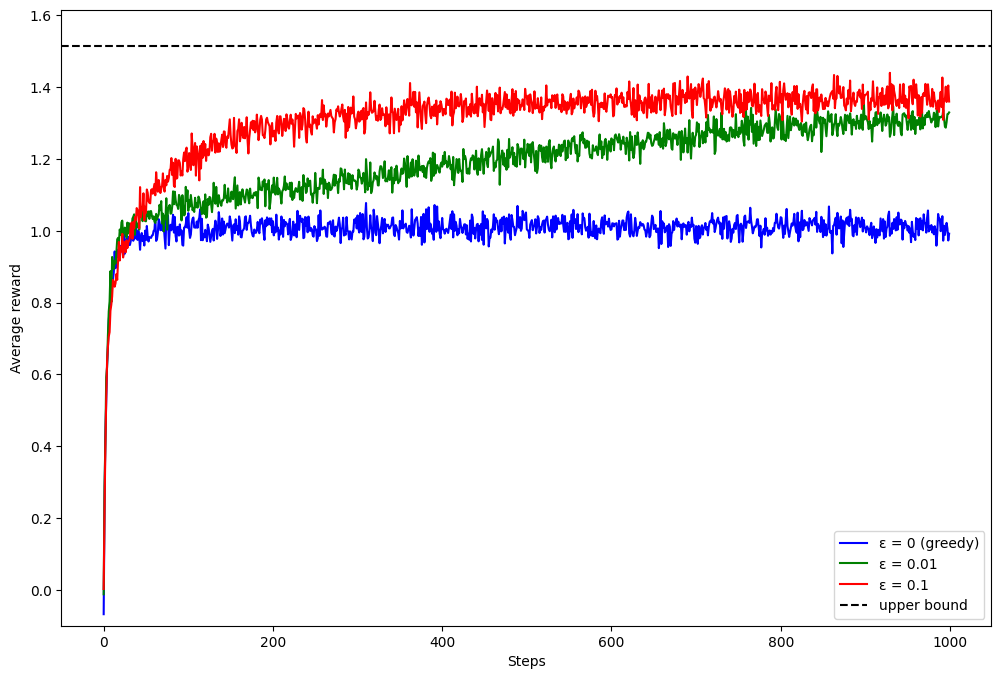

In [8]:
# Plot the "Average reward" figure
plot_curves([rewards_eps0, rewards_eps001, rewards_eps01],
            ["ε = 0 (greedy)", "ε = 0.01", "ε = 0.1"], 
            ["blue", "green", "red"],
            upper_bound_eps0,
            "Average reward")

<Figure size 640x480 with 0 Axes>

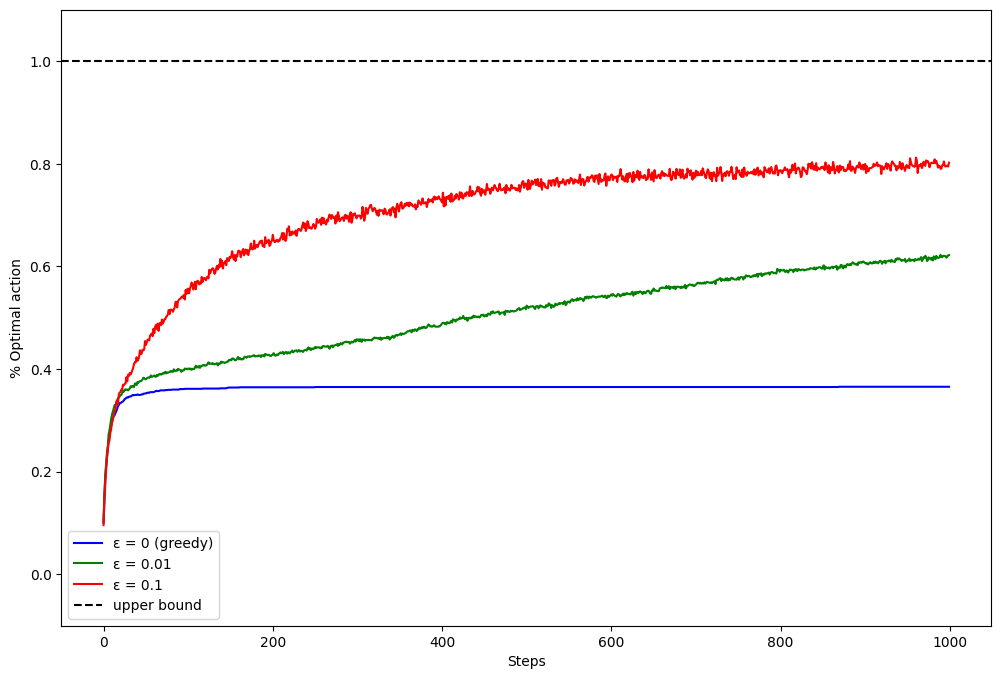

In [9]:
# Plot the "% Optimal action" figure
plot_curves([actions_eps0, actions_eps001, actions_eps01],
            ["ε = 0 (greedy)", "ε = 0.01", "ε = 0.1"],
            ["blue", "green", "red"],
            np.ones(run_num), # should be 100%
            "% Optimal action")

### Written Answer

Convergence Values:

ε = 0 (greedy): ≈ 1.0
ε = 0.01: ≈ 1.3
ε = 0.1: ≈ 1.4
Upper bound: ≈ 1.5
Why Different ε Values Converge to Different Rewards:

ε = 0 (greedy) performs worst because it never explores. After a few initial samples, it commits entirely to whichever action looked best based on noisy early rewards. Since the true optimal action differs across bandit problems, the greedy agent often gets permanently stuck on a suboptimal action (only ~35% optimal action selection).

ε = 0.1 achieves the highest average reward in this timeframe because 10% exploration allows it to quickly discover the optimal action (~80% optimal selection). However, it cannot reach the upper bound because it perpetually spends 10% of actions on random exploration, often selecting suboptimal actions.

ε = 0.01 is intermediate - it explores slowly (only 1% of actions), so it takes longer to identify the optimal action (~62% optimal by step 1000). However, with more time, ε = 0.01 would eventually surpass ε = 0.1 because it wastes fewer actions on exploration.

Conclusion: Different ε values represent different exploration-exploitation trade-offs. Higher ε finds the best action faster but limits long-term performance; lower ε may never find the best action if it gets stuck early.


# Q3: Implement the ε-greedy algorithm with optimistic initial values, and the bandit algorithm with UCB action selection

In [10]:
""" Reproducing the Figure 2.3.
Please note, instead of using the sample-average technique,
Use equation 2.5 to update the Q values with \alpha=0.1
"""
class EpsilonGreedyAgent(object):
    def __init__(self, k: int, init: int, epsilon: float, alpha: float = None) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            epsilon (float): random action probability
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.epsilon = epsilon
        #added alpha value for 2.5
        self.alpha = alpha

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self) -> int:
        """Choose which arm to pull

        With probability 1 - epsilon, choose the best action (break ties arbitrarily, use argmax() from above).
        
        With probability epsilon, choose a random action.
        """
        # CODE HERE: please implement the epsilon-greedy strategy to select the action

        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return self.argmax(self.Q)

        
        # return int

    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1
        # update the self.N
        self.N[action] += 1

        # CODE HERE: implement the incremental update
        
        #determine the step size
        if self.alpha is not None:
            step_size = self.alpha
        else:
            step_size = 1.0 / self.N[action]
        self.Q[action] += step_size * (reward - self.Q[action])
        # CODE HERE: update self.Q with the incremental update
        # Note: For reproducing Figure 2.3, implement the exponential average (equation 2.5)
        # Note: For reproducing Figure 2.4, implement the sample average (equation 2.1)


    @staticmethod
    def argmax(arr) -> int:
        """Argmax that breaks ties randomly

        Takes in a list of values and returns the index of the item with the highest value, breaking ties randomly.

        Note: np.argmax returns the first index that matches the maximum, so we define this method to use in EpsilonGreedy and UCB agents.
        Args:
            arr: sequence of values
        """
        #CODE HERE: implement argmax_a Q(a) for the greedy action selection, breaking ties randomly.
        max_val = np.max(arr)
        max_indices = np.where(arr == max_val)[0]
        return np.random.choice(max_indices)    
        

In [11]:
""" Here is the implementation of the UCB agent. Please complete the missing part.
"""
class UCBAgent(object):
    def __init__(self, k: int, init: int, c: float) -> None:
        """Epsilon greedy bandit agent

        Args:
            k (int): number of arms
            init (init): initial value of Q-values
            c (float): UCB constant that controls degree of exploration
        """
        # Number of the arms. For example, k = 10 for 10-armed Bandit problem
        self.k = k

        # Initial Q value
        self.init = init

        # Epsilon value
        self.c = c

        # Q-values for each arm
        self.Q = None
        # Number of times each arm was pulled
        self.N = None
        # Current total number of steps
        self.t = None

    def reset(self) -> None:
        """Initialize or reset Q-values and counts

        This method should be called after __init__() at least once
        """
        self.Q = self.init * np.ones(self.k, dtype=np.float32)
        self.N = np.zeros(self.k, dtype=int)
        self.t = 0

    def choose_action(self):
        """Choose which arm to pull

        Use UCB action selection. Be sure to consider the case when N_t = 0 and break ties randomly (use argmax() from above)
        """
        # CODE HERE: use UCB to select the action. Be sure to consider the case when N_t = 0
        # and break ties randomly (use argmax() from above). The return should be an integer
        # index of the action.
        # return int

        ucb_vals = np.zeros(self.k)
        for i in range(self.k):
            if self.N[i] == 0:
                return i #max exploration
            else:
                #implement the exact formula 
                ucb_vals[i] = self.Q[i] + self.c * np.sqrt(np.log(self.t) / self.N[i])
        
        return np.argmax(ucb_vals)


    def update(self, action: int, reward: float) -> None:
        """Update Q-values and N after observing reward.

        Args:
            action (int): index of pulled arm
            reward (float): reward obtained for pulling arm
        """
        # increase the time step
        self.t += 1
        # update the self.N
        self.N[action] += 1 

        # CODE HERE: implement the incremental update
        
        #sample average 
        self.Q[action] += (1.0 / self.N[action]) * (reward - self.Q[action])


        # CODE HERER: update self.
        # Note: For reproducing Figure 2.3, implement the exponential average (equation 2.5)
        # Note: For reproducing Figure 2.4, implement the sample average (equation 2.1)


In [12]:
"""Here is the implementation of running the UCB agent. Please complete the missing part.
"""
# run epsilon greedy 
def run_ucb_agent(run_num, time_step, c):
    # create the 10-armed Bandit problem
    k = 10
    env = Bandit(k)
    env.reset()

    # create the agent
    my_agent = UCBAgent(k=k, init=0.0, c=c)
    my_agent.reset()

    # create a numpy array
    results_rewards = np.empty((run_num, time_step))
    
    # create a numpy array
    results_action = np.empty((run_num, time_step))

    # loop starts
    upper_bound = np.empty(run_num)
    for r in tqdm.tqdm(range(run_num), desc="run number", position=0):
       
        # CODE HERE: reset the environment and the agent
        # create a new 10-armed bandit problem
        # CODE HERE: create a new agent

        env.reset()
        my_agent.reset()
        
       
        # CODE HERE: update upper_bound[r]
        upper_bound[r] = np.max(env.q_star)
        for t in tqdm.tqdm(range(time_step), desc="time step", position=1, leave=False):
            # CODE HERE: choose action for time step t
            act = my_agent.choose_action()

            # CODE HERE: interact with the environment
            reward = env.step(act)

            # CODE HERE: update the bandit agent with the observed reward
            my_agent.update(act, reward)
            
            # save the reward
            results_rewards[r, t] = reward
            # compute the optimality
            if act in env.best_action():
                results_action[r, t] = 1
            else:
                results_action[r, t] = 0
            
    return results_rewards, results_action, upper_bound

# Reproduce Figure 2.3 using exponential average (equation 2.5 with alpha = 0.1)

In [13]:
"""Here is the implementation for running the experiment. You have to run the "run_ucb_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 1000
"""
# set the running parameters
run_num = 2000 
time_step = 1000
    
# CODE HERE: 
# 1. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.0
rewards_1, actions_1, upper_bound = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.0, init=0.0, alpha=0.1
)
# 2. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.0 
rewards_2, actions_2, _ = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.0, init=5.0, alpha=0.1
)
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1 
rewards_3, actions_3, _ = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=0.0, alpha=0.1
)
# 4. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.1 
rewards_4, actions_4, _ = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=5.0, alpha=0.1
)
# 5. Run the UCB agent experiment for c=2
rewards_5, actions_5, _ = run_ucb_agent(
    run_num=run_num, time_step=time_step, c=2
)


run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

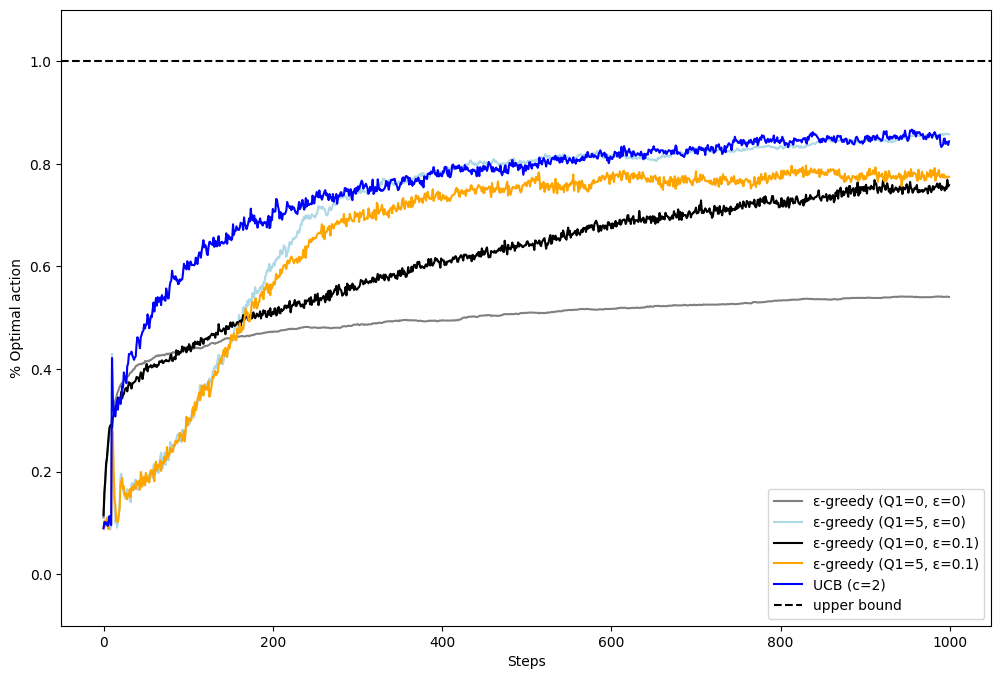

In [14]:
# Plot the "% Optimal action" figure
plot_curves([actions_1, actions_2, actions_3, actions_4, actions_5],
            ["ε-greedy (Q1=0, ε=0)", "ε-greedy (Q1=5, ε=0)", "ε-greedy (Q1=0, ε=0.1)", "ε-greedy (Q1=5, ε=0.1)", "UCB (c=2)"],
            ["gray", "lightblue", "black", "orange", "blue"],
            np.ones(run_num), # Upper bound is 100%
            "% Optimal action")

# Reproduce Figure 2.4 using sample average (equation 2.1)

In [15]:
"""Here is the implementation for running the experiment. You have to run the "run_ucb_agent" function
   for multiple times for different parameter combination. Please use smaller run_num and time_step for Debug only.
   For example, run_num = 100, time_step = 1000
"""
# always set the random seed for results reproduction
np.random.seed(1234)
random.seed(1234)

# set the number of run
run_num = 2000
# set the number of time steps
time_step = 1000

# CODE HERE: 
# 1. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.0
rewards_1, actions_1, upper_bound = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.0, init=0.0, alpha=0.1
)
# 2. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.0
rewards_2, actions_2, upper_bound = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.0, init=5.0, alpha=0.1
) 
# 3. Run the epsilon-greedy agent experiment for initial value = 0.0, epsilon = 0.1 
rewards_3, actions_3, _ = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=0.0, alpha=0.1
)
# 4. Run the epsilon-greedy agent experiment for initial value = 5.0, epsilon = 0.1 
rewards_4, actions_4, _ = run_epsilon_greedy_agent(
    run_num=run_num, time_step=time_step, epsilon=0.1, init=5.0, alpha=0.1
)
# 5. Run the UCB agent experiment for c=2
rewards_5, actions_5, _ = run_ucb_agent(
    run_num=run_num, time_step=time_step, c=2
)

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

run number:   0%|          | 0/2000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

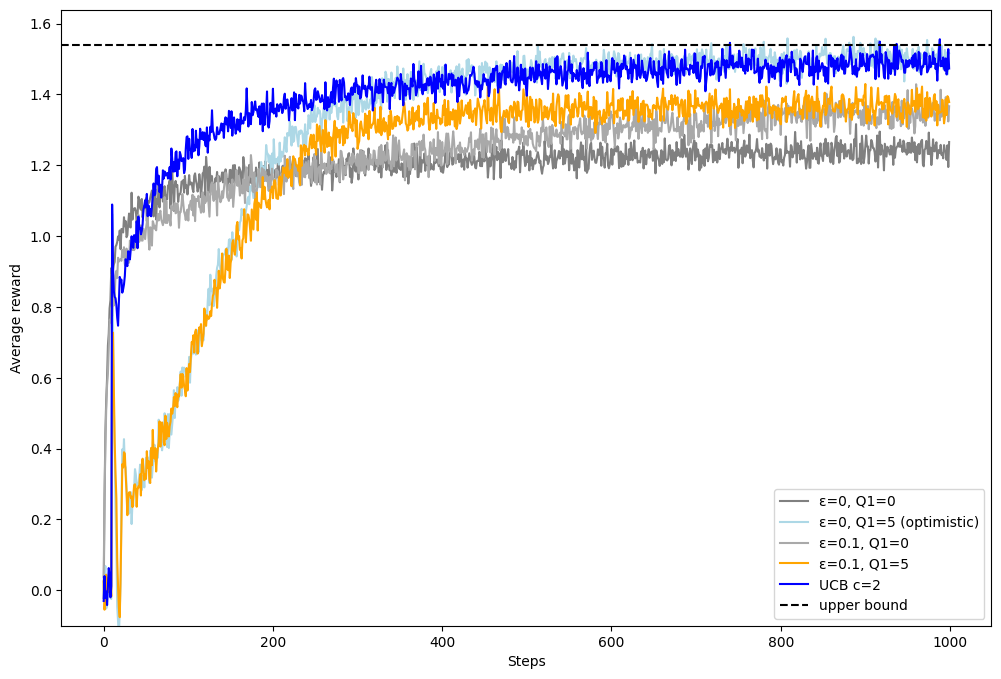

In [16]:
# Plot the "Average reward" figure
plot_curves(
    [rewards_1, rewards_2, rewards_3, rewards_4, rewards_5],
    ["ε=0, Q1=0", "ε=0, Q1=5 (optimistic)", "ε=0.1, Q1=0", "ε=0.1, Q1=5", "UCB c=2"],
    ["gray", "lightblue", "darkgray", "orange", "blue"],
    upper_bound,
    "Average reward"
)